In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#imports section
import pandas_datareader.data as web
import numpy as np
import pandas as pd
import cvxpy as cvx
import re, os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from math import *
from datetime import datetime, date, time, timedelta
from time import sleep
from mvo_utils_v2 import *
from fbprophet import Prophet
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [3]:
# L/S utility functions

# long-short version of recommend allocations
def ls_recommend_allocs(px, lb, net_exp, lev, min_w, max_w, gamma_val):
    px = clean_nas(px) # clean dataframe
    px_portion = px[-lb:] # subselect the period to optimize; frame and lb were duplicatives
    returns, alloc = ls_get_weights(
        px_portion, lb, net_exp, lev, min_w, max_w, gamma_val) # subselect the period to optimize
    port_perf = calc_port_performance(returns.values, alloc.values)
    pdf = pd.DataFrame(port_perf, index=returns.index, columns=["Quantum"])
    return px_portion, returns, alloc, pdf

# long-short version of optimization, position weights
def ls_get_weights(px, lb, min_sum, max_sum, min_w, max_w, gamma_val):
    lb_rets = px.sort_index().pct_change().fillna(0) # capture the last lb days going back
    n = lb_rets.shape[1]; mu = lb_rets.mean().values.T; Sigma = lb_rets.cov().values
    w = cvx.Variable(n)
    gamma = cvx.Parameter(sign='positive')
    Lmax = cvx.Parameter()
    ret = mu.T * w; risk = cvx.quad_form(w, Sigma)
    lo_obj = cvx.Maximize(ret - gamma*risk)
    ls_const = [cvx.sum_entries(w) == min_sum, cvx.norm(w, 1) < Lmax, w <= max_w, w >= min_w]
    prob = cvx.Problem(lo_obj, ls_const)
    gamma.value = gamma_val; Lmax.value = max_sum
    prob.solve()
    weights = w.value if prob.status == 'optimal' else np.zeros((n, 1))
    np_weights = np.array(weights)
    lb_weights = pd.DataFrame(np_weights.T, index=[lb_rets.index[-1]], columns=lb_rets.columns)
    return lb_rets, lb_weights

# pending implementation using partials
def quick_gamma(glist, px, lb, net_exp, lev, min_w, max_w):
    if len(glist) <= 1: 
        mid_g = glist[0]
        mid_sr = get_sr_for_opt(px, lb, net_exp, lev, min_w, max_w, mid_g)
        return mid_g, mid_sr
    else:
        mid = len(glist)//2; left = glist[:mid]; right = glist[mid:]
        mid_l = left[len(left)//2]; mid_r = right[len(right)//2]
        left_sr = get_sr_for_opt(px, lb, net_exp, lev, min_w, max_w, mid_l)
        right_sr = get_sr_for_opt(px, lb, net_exp, lev, min_w, max_w, mid_r)
        sublist = left if left_sr > right_sr else right
        #if left_sr > right_sr: sublist = left
        #else: sublist = right
        return quick_gamma(sublist, px, lb, net_exp, lev, min_w, max_w)

# return portfolio sharpe for a given optimization
def get_sr_for_opt(px, lb, net_exp, lev, min_w, max_w, gamma):
    px_p, _, alloc, pdf = ls_recommend_allocs(px, lb, net_exp, lev, min_w, max_w, gamma)
    rec = last_allocation(alloc, 0.01)
    ret, risk = port_metrics(px_p, rec)
    return ret / risk

# cleans small positions in long-short portfolios based on minimum weight criteria
def filter_ls(rec, pos_filter):
    long = rec[(rec > pos_filter).values]; short = rec[(rec < -pos_filter).values]
    return long.append(short)

#calculates the historical allocations based on a date frequency
def get_hist_allocs(rebal_freq, px, lb, g_samples, min_len, pos_filter):
    px = clean_nas(px)
    as_of_idx = px.head(1).combine_first(px.asfreq(rebal_freq)).dropna()
    hist_allocs = pd.DataFrame([], index=as_of_idx.index)
    if log: print(len(as_of_idx.index), "rebalances"); print(as_of_idx.index)
    for d in as_of_idx.index:
        subset = px.loc[:d]; days = len(subset)
        if days < min_len: continue
        gamma_val, gamma_sr = quick_gamma(gamma_vals, subset, lb, net_exposure, leverage, min_weight, max_weight)
        if log: print("rebalancing: {0}, {1:.2f}, {2:.2f}".format(d, gamma_val, gamma_sr))
        px_portion, returns, alloc, pdf = ls_recommend_allocs(
            subset, lb, net_exposure, leverage, min_weight, max_weight, gamma_val)
        rec = last_allocation(alloc, min_weight)
        l_s = filter_ls(rec, pos_filter)
        hist_allocs = hist_allocs.combine_first(alloc[l_s.index])
    return hist_allocs

# alings allocations with trading days
def align_ret_allocs(allocs, px):
    rets = px[allocs.columns].pct_change().fillna(0)
    resampled_alloc = allocs.resample('D').pad()
    resampled_alloc = resampled_alloc.loc[rets.index]
    return rets, resampled_alloc

# explicit function to review global vars
def print_global_vars():
    global_vars_fmt = "Global Variables\n" \
    "Refresh Pricing: {}\n" + "Historical Time Window: {}\n" + "Lookback: {}\n" \
    + "Rebalance Frequency: {}\n" + "Net Exposure: {}\n" \
    + "Leverage: {}\n" + "Weights: min {} to max {}\n" + "Universe: {}\n"
    print(global_vars_fmt.format(
        refresh_pricing, hist_window, lookback, 
        rebal_frequency, net_exposure, 
        leverage, min_weight, max_weight,
        universe))

# summary plots
def plot_bt_summary(df):
    pct_chg_df = df.pct_change()
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15,3), dpi=300)
    compound(df).plot(ax=ax1, x_compat=True)
    ax1.yaxis.set_label('Indexed Return')
    pct_chg_df.plot.hist(ax=ax2, stacked=True, bins=20)
    pct_chg_df.boxplot(ax=ax3)
    pct_chg_df.plot.kde(ax=ax4)
    print(pct_chg_df.describe().applymap(short_float))
    
# create portfolio risk metric matrix for net exposure selection
TS_METRICS_LEGEND = ['Return', 'Risk', 'RSpread', 'Sharpe', 'MaxDraw']
def ts_metrics(pdf):
    timespan = len(pdf.index)
    ret = (pdf.pct_change().mean() * timespan)
    std = (pdf.pct_change().std() * sqrt(timespan))
    mdd = max_drawdown(pdf)[0];
    
    return ret, std, ret - std, ret / std, mdd

# calculates max drawdown, largest reduction from highest point
def max_drawdown(xs):
    i = np.argmax(np.maximum.accumulate(xs) - xs) # end of the period
    j = np.argmax(xs[:i]) # start of period
    pct_mdd = -1 * ((xs[j] - xs[i]) / xs[j])
    return pct_mdd, j, i

# plots max drawdown chart
def plot_max_drawdown(xs):
    _, j, i = max_drawdown(xs)
    plt.plot(xs)
    plt.legend()
    plt.plot([i, j], [xs[i], xs[j]], 'o', color='Red', markersize=5)


def est_price(x):
    name =x.reset_index().columns[1]
    df = x.reset_index().rename(columns={'Date':'ds', name:'y'})
    df['y'] = np.log(df['y'])
    model = Prophet()#weekly_seasonality=True,yearly_seasonality=True,daily_seasonality=True)
    model.fit(df)
    future = model.make_future_dataframe(periods=21) #forecasting for 7 days from now.
    forecast = model.predict(future)
    #figure=model.plot(forecast)
    est = forecast.set_index('ds').join(x)
    est['yhat']=np.exp(est.yhat)
    print(name)
    #est['yhat_upper']=np.exp(est.yhat_upper)
    #est['yhat_lower']=np.exp(est.yhat_lower)
    #est=x.combine_first(est["yhat"])
    #est=x.update(est["yhat"])
    #est=x.join(est)
    #est=est["yhat"]
    #est=pd.DataFrame(est)
    #est.columns=[name]
    #est.index.name="Date"
    #from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
    #aux=est.dropna()
    #r2=r2_score(aux[name], aux.yhat)
    #MAE=mean_absolute_error(aux[name], aux.yhat)
    #MSE=mean_squared_error(aux[name], aux.yhat)
    #df_metrics=pd.DataFrame(columns=["r2", "MAE","MSE"], data=[[r2,MAE,MSE]],index=[name])
    return est["yhat"]#,df_metrics

def plot_bt_summary2(df):
    pct_chg_df = df.pct_change().dropna()
    gs = gridspec.GridSpec(3, 6, height_ratios= [80,10, 30]) 
    fig1 = plt.figure(figsize=(12,10))
    ax1 =plt.subplot(gs[0,:])
    compound(df).plot(ax=ax1, x_compat=True)
    ax1.yaxis.set_label('Indexed Return')
    fig2 = plt.figure(figsize=(10,7))
    j=1
    for i in range(len(net_exp_port.columns)):
        x = pct_chg_df[pct_chg_df.columns[i]].dropna().values
        ax_box = plt.subplot(gs[j,i])
        ax_hist = plt.subplot(gs[j+1,i],sharex=ax_box)
        sns.boxplot(x, ax=ax_box).set_title("net exp :"+str(pct_chg_df.columns[i]))
        ax_box.set_xticklabels(ax_box.get_xticklabels(),rotation=30)
        sns.distplot(x, ax=ax_hist)
        ax_hist.set_xticklabels(ax_hist.get_xticklabels(),rotation=30)
        ax_box.set(yticks=[])
        sns.despine(ax=ax_hist)
        sns.despine(ax=ax_box, left=True)
    plt.tight_layout()
    print(pct_chg_df.describe().applymap(short_float))

In [264]:
# Global variables
log = True
refresh_pricing = False
universe = 'spy-sectors'  # 'spy_sectors OR 'ark_etfs'
active_etf = None  # ETF name OR None for broad market

#variables for performance analysis
lookback = 60
net_exposure = 0
leverage = 1
min_weight = -0.05
max_weight = 0.05  # default optimization vars
min_len = 3
pos_filter = 0.01  # cleaning variables
rebal_frequency = 'W-' + datetime.now().strftime('%a')  # for historical allocations
gamma_vals = np.logspace(-1, 3, num=25)  # 1 to 1000 range

net_exposures = np.arange(0.0, 1.01, 0.2)
left_substr = lambda a, i: [str(c)[:i] for c in a.columns.tolist()]
BACKTEST_PATH = './backtests/'
RECOMMENDATION_PATH = './recommendations/'
FNAME_INDEX = "{}backtest-{}-{}.csv"
FNAME_ALLOC = "{}allocs-{}-{}-{}.csv"
FNAME_RETURN = "{}returns-{}-{}-{}.csv"
FNAME_GEN = "{}{}-{}-{}-{}.csv"

print_global_vars()

Global Variables
Refresh Pricing: False
Historical Time Window: 100
Lookback: 60
Rebalance Frequency: W-Mon
Net Exposure: 0
Leverage: 1
Weights: min -0.05 to max 0.05
Universe: spy-sectors



In [265]:
# load spy sector components
# would be nice to load a JSON with configuration
ticker_map = {
    'benchmark': ['SPY'],
    'equity': ['VTI','VTV','VOE','VBR','VEA','VWO'],
    'fixed_income': ['VTIP', 'SHV', 'MUB', 'LQD', 'BNDX', 'EMB'],
    'spy-sectors': ['XLE', 'XLU', 'XLK', 'XLB', 'XLP', 'XLY', 'XLI', 'XLV', 'XLF', 'XLRE'],
    'ark-etfs': ['ARKG', 'ARKK', 'ARKQ', 'ARKW']
}

config = {
    'spy-sectors' : {
        'hold_cols': ['Symbol','Company Name', 'Index Weight'],
        'hold_format': r'holdings-spy-',
        'idx_col': 'Symbol',
        'fname': 'spy-sectors',
        'skiprows': 1
    },
    'ark-etfs' : {
        'hold_cols': ['ticker','company', 'weight(%)'],
        'hold_format': r'holdings-ark-',
        'idx_col': 'ticker',
        'fname': 'ark-etfs',
        'skiprows': 0
    }
}

hold_cols = config[universe]['hold_cols']
hold_format = config[universe]['hold_format']
idx_col = config[universe]['idx_col']
fname = config[universe]['fname']
skiprows = config[universe]['skiprows']

companies = load_components(
    companies, hold_format, hold_cols, 
    idx_col, ticker_map[universe], srows=skiprows)
print("Companies loaded:", companies.shape)
px_etfs = load_pricing(fname + '.csv', 'Date')
px_spy = load_pricing('SPY.csv', 'Date')

Companies loaded: (1010, 3)
Loaded pricing for spy-sectors.csv, with shape (69, 10)
Loaded pricing for SPY.csv, with shape (2757, 1)


In [266]:
# Load pricing for components of each sectors
px_etfs = load_pricing(universe + '.csv', 'Date')
px_spy = load_pricing('SPY.csv', 'Date')
consol_px = clean_nas(load_consol_px(ticker_map, universe))
if(active_etf != None): companies = companies[companies['ETF']==active_etf] # filter by selected ETF
tickers = companies.index.tolist()
tickers=[i for i in tickers if i not in ['BF.b','BRK.b']] ## esta es una correcion extra para no incluir 'BF.b','BRK.b'
consol_px = consol_px[list(set(tickers))]

Loaded pricing for spy-sectors.csv, with shape (69, 10)
Loaded pricing for SPY.csv, with shape (2757, 1)
Loaded pricing for XLE-hold-pricing.csv, with shape (2605, 31)
Loaded pricing for XLU-hold-pricing.csv, with shape (2605, 28)
Loaded pricing for XLK-hold-pricing.csv, with shape (2605, 73)
Loaded pricing for XLB-hold-pricing.csv, with shape (2605, 25)
Loaded pricing for XLP-hold-pricing.csv, with shape (2605, 34)
Loaded pricing for XLY-hold-pricing.csv, with shape (2605, 82)
Loaded pricing for XLI-hold-pricing.csv, with shape (2605, 70)
Loaded pricing for XLV-hold-pricing.csv, with shape (2605, 61)
Loaded pricing for XLF-hold-pricing.csv, with shape (2605, 68)
Loaded pricing for XLRE-hold-pricing.csv, with shape (2605, 33)


In [267]:
# Removing tickers for M&A targets and diff class shares of same co.
remove_tickers = ['CSRA', 'DPS', 'UAA', 'DISCK', 'JUNO', 'XL', 'WELL', 'BKNG', 'SNI','EVGN', 'CBRE']
remove = list(set(remove_tickers).intersection(consol_px.columns.tolist()))
if len(remove) > 0: consol_px.drop(remove, axis=1, inplace=True)
consol_px.shape
consol_px = consol_px[sorted(consol_px.columns.tolist())]
consol_px.to_csv("consol_algo.csv")
consol_px.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2605 entries, 2007-11-16 to 2018-03-23
Columns: 495 entries, A to ZTS
dtypes: float64(495)
memory usage: 9.9 MB


In [262]:
#date_fmt = '%Y-%m-%d'
#start_date = datetime.now() - timedelta(4000)
#start_date = start_date.strftime(date_fmt)
#start_date
#get_safe_pricing('SPY.csv', ['SPY'], start_date)

('2007-04-20', 100)

            0.0       0.2       0.4       0.6       0.8       1.0
count  2578.000  2578.000  2578.000  2578.000  2578.000  2578.000
mean      0.001     0.001     0.001     0.001     0.001     0.001
std       0.010     0.008     0.007     0.007     0.006     0.005
min      -0.098    -0.095    -0.093    -0.076    -0.035    -0.039
25%      -0.002    -0.002    -0.002    -0.002    -0.002    -0.001
50%       0.001     0.001     0.001     0.001     0.001     0.000
75%       0.005     0.004     0.004     0.004     0.003     0.003
max       0.075     0.058     0.047     0.042     0.037     0.040


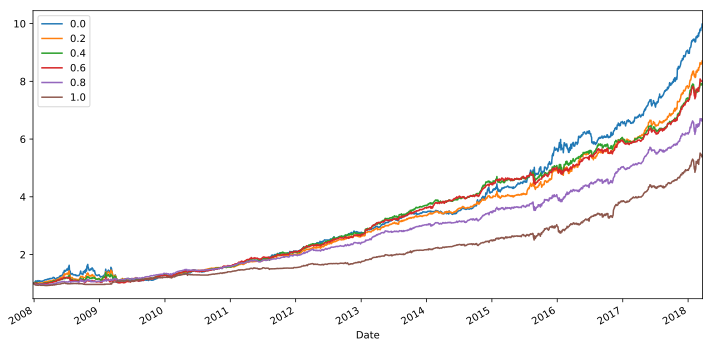

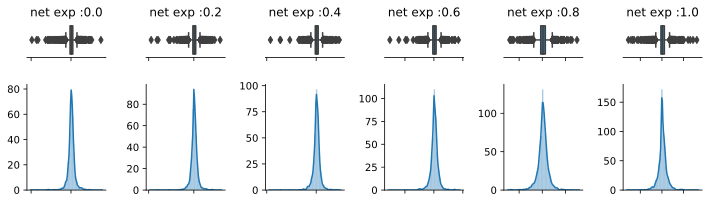

In [8]:
# 4. what are the net exposures with weekly rebalances?
log = True
time_frame = '2007-12-25'; rebal_frequency = 'W-WED'
subset = consol_px[time_frame:]
fname = FNAME_INDEX.format(BACKTEST_PATH, time_frame, rebal_frequency)

try:
    net_exp_port = pd.read_csv(fname, index_col='Date', parse_dates=True)
    net_exp_port.columns = left_substr(net_exp_port, 3)
    plot_bt_summary2(net_exp_port)
    # conclusion: see that the 0 net exposure acheives the best "cumulative" returns
    # however, there are a fair amount of outliers in the boxplot
    # need to decompose into years to understand the behaviour

except Exception as err:
    print("Error: {0}, please run backtest below".format(err))
    # this will take a while
    log = True
    net_exp_portfolios = pd.DataFrame([])
    for ne in net_exposures:
        net_exposure = ne
        hist_allocs = get_hist_allocs(rebal_frequency, subset, lookback, gamma_vals, min_len, pos_filter)
        returns, allocs = align_ret_allocs(hist_allocs, subset)
        time_series = calc_port_performance(returns, allocs).to_frame()
        time_series.columns = [ne]
        net_exp_portfolios = net_exp_portfolios.combine_first(time_series.copy())
        returns.to_csv(FNAME_GEN.format(BACKTEST_PATH, 'returns', ne, time_frame, rebal_frequency))
        allocs.to_csv(FNAME_GEN.format(BACKTEST_PATH, 'allocs', ne, time_frame, rebal_frequency))
    net_exp_portfolios.to_csv(FNAME_INDEX.format(BACKTEST_PATH, time_frame, rebal_frequency))

In [235]:
net_exp_port = pd.read_csv(fname, index_col='Date', parse_dates=True)
net_exp_port.columns = left_substr(net_exp_port, 3)
#plot_bt_summary2(net_exp_port)
returns_1= pd.read_csv(BACKTEST_PATH+"returns-1.0-2007-12-25-W-WED.csv",index_col="Date")
returns_6= pd.read_csv(BACKTEST_PATH+"returns-0.6000000000000001-2007-12-25-W-WED.csv",index_col="Date")
returns_8= pd.read_csv(BACKTEST_PATH+"returns-0.8-2007-12-25-W-WED.csv",index_col="Date")
returns_4= pd.read_csv(BACKTEST_PATH+"returns-0.4-2007-12-25-W-WED.csv",index_col="Date")
returns_2= pd.read_csv(BACKTEST_PATH+"returns-0.2-2007-12-25-W-WED.csv",index_col="Date")
returns_0= pd.read_csv(BACKTEST_PATH+"returns-0.0-2007-12-25-W-WED.csv",index_col="Date")
backtest_2007 = pd.read_csv(BACKTEST_PATH+"backtest-2007-12-25-W-WED.csv")
allocs_1= pd.read_csv(BACKTEST_PATH+"allocs-1.0-2007-12-25-W-WED.csv",index_col="Date")
allocs_6= pd.read_csv(BACKTEST_PATH+"allocs-0.6-2007-12-25-W-WED.csv",index_col="Date")
allocs_8= pd.read_csv(BACKTEST_PATH+"allocs-0.8-2007-12-25-W-WED.csv",index_col="Date")
allocs_4= pd.read_csv(BACKTEST_PATH+"allocs-0.4-2007-12-25-W-WED.csv",index_col="Date")
allocs_2= pd.read_csv(BACKTEST_PATH+"allocs-0.2-2007-12-25-W-WED.csv",index_col="Date")
allocs_0= pd.read_csv(BACKTEST_PATH+"allocs-0.0-2007-12-25-W-WED.csv",index_col="Date")
# net_exp_port 2007-12-25 W-WED

In [219]:
#aux[net_exposure]
def get_port_perf(net_exposure,first,last):
    if net_exposure =="0.0":
        x=calc_port_performance(returns_0,allocs_0).loc[last:first].to_frame()
    elif net_exposure =="0.2":
        x=calc_port_performance(returns_2,allocs_2).loc[last:first].to_frame()
    elif net_exposure =="0.4":
        x=calc_port_performance(returns_4,allocs_4).loc[last:first].to_frame()
    elif net_exposure =="0.6":
        x=calc_port_performance(returns_6,allocs_6).loc[last:first].to_frame()
    elif net_exposure =="0.8":
        x=calc_port_performance(returns_8,allocs_8).loc[last:first].to_frame()
    else:
        x=calc_port_performance(returns_1,allocs_1).loc[last:first].to_frame()
    return x



In [358]:
#aux[net_exposure]
def get_return(net_exposure,first,last):
    if net_exposure =="0.0":
        x=(np.sum(returns_0 * allocs_0, axis=1) + 1).to_frame().loc[last:first]
    elif net_exposure =="0.2":
        x=(np.sum(returns_2 * allocs_2, axis=1) + 1).to_frame().loc[last:first]
    elif net_exposure =="0.4":
        x=(np.sum(returns_4 * allocs_4, axis=1) + 1).to_frame().loc[last:first]
    elif net_exposure =="0.6":
        x=(np.sum(returns_6 * allocs_6, axis=1) + 1).to_frame().loc[last:first]
    elif net_exposure =="0.8":
        x=(np.sum(returns_8 * allocs_8, axis=1) + 1).to_frame().loc[last:first]
    else:
        x=(np.sum(returns_1 * allocs_1, axis=1) + 1).to_frame().loc[last:first]
    x.index=pd.to_datetime(x.index)
    return x


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel_launcher.py:112: RuntimeWarning: invalid value encountered in double_scalars


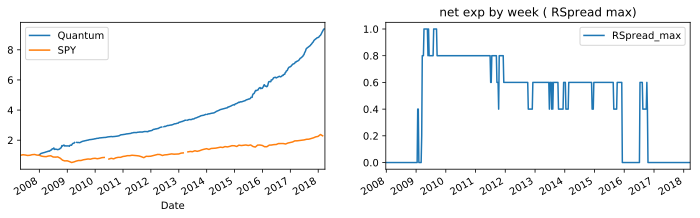

In [435]:
as_of_idx = net_exp_port.head(1).combine_first(net_exp_port.asfreq("W-WED")).dropna()
w_wed_net_exp=pd.DataFrame([],index=as_of_idx.index.tolist(),columns=["RSpread_max"])
df=pd.DataFrame([])

last=str(as_of_idx.index.tolist()[0].date())
for i in as_of_idx.index.tolist():
    aux=net_exp_port[:i]
    if len(aux)>1:
        #compound(df).plot(ax=ax1, x_compat=True)
        port_risk_matrix = lambda x: pd.Series([x for x in ts_metrics(x)], index=TS_METRICS_LEGEND)
        risk_matrix = aux.apply(port_risk_matrix)
        net_exposure = float(risk_matrix.loc['RSpread'].argmax())
        #df=df.append(get_port_perf(net_exposure))
        w_wed_net_exp.loc[i]=net_exposure
        df=df.combine_first(get_return(str(net_exposure),str(i.date()),last))
        last=str(i.date())


w_wed_net_exp
df.columns=["Quantum"]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,3), dpi=300)
np.cumprod(df.drop_duplicates().asfreq("W-WED")).plot(ax=ax1, x_compat=True)
compound(px_spy.asfreq("BM")).plot(ax=ax1, x_compat=True)
w_wed_net_exp.plot(ax=ax2)
plt.title("net exp by week ( RSpread max)")
plt.show()

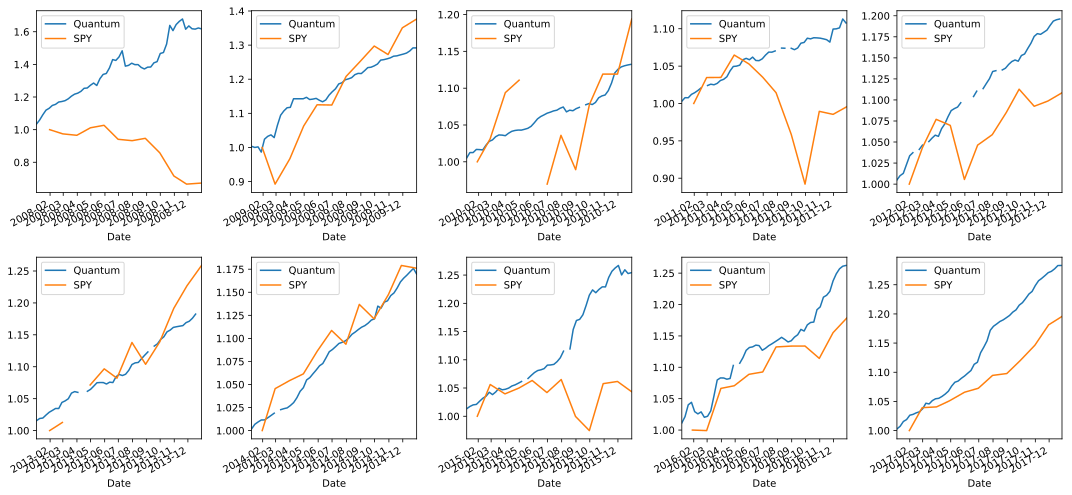

In [441]:
### retornos mensuales de spy vs, retornos de quatntum por año
gs = gridspec.GridSpec(2, 5)#, height_ratios= [80,10, 30]) 
fig2 = plt.figure(figsize=(15,7))
plt.xticks(rotation=90)
j=0
i=0
for k in np.arange(2008,2018,1):
    if k==2013:
        j=1;i=0
    ax_box = plt.subplot(gs[j,i])
    #print(j,i,k)
    np.cumprod(df[str(k)].asfreq("W-WED")).plot(ax=ax_box, x_compat=True)
    compound(px_spy[str(k)].asfreq("BM")).plot(ax=ax_box, x_compat=True)
    plt.tight_layout()
    i=i+1
plt.show()

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel_launcher.py:112: RuntimeWarning: invalid value encountered in double_scalars


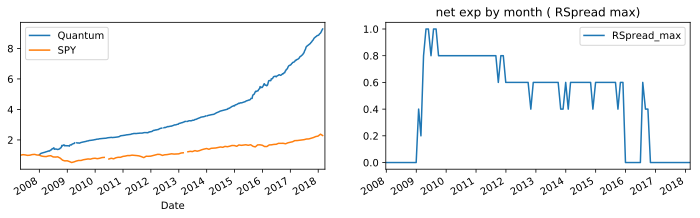

In [371]:
as_of_idx = net_exp_port.head(1).combine_first(net_exp_port.asfreq("BM")).dropna()
m_net_exp=pd.DataFrame([],index=as_of_idx.index.tolist(),columns=["RSpread_max"])
df=pd.DataFrame([])#,index=net_exp_port.index)

last=str(as_of_idx.index.tolist()[0].date())
for i in as_of_idx.index.tolist():
    aux=net_exp_port[:i]
    if len(aux)>1:
        port_risk_matrix = lambda x: pd.Series([x for x in ts_metrics(x)], index=TS_METRICS_LEGEND)
        risk_matrix = aux.apply(port_risk_matrix)
        net_exposure = float(risk_matrix.loc['RSpread'].argmax())
        m_net_exp.loc[i]=net_exposure
        df=df.combine_first(get_return(str(net_exposure),str(i.date()),last))
        last=str(i.date())

m_net_exp
df.columns=["Quantum"]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,3), dpi=300)
np.cumprod(df.drop_duplicates().asfreq("W-WED")).plot(ax=ax1, x_compat=True)
compound(px_spy.asfreq("BM")).plot(ax=ax1, x_compat=True)
m_net_exp.plot(ax=ax2)
plt.title("net exp by month ( RSpread max)")
plt.show()

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel_launcher.py:112: RuntimeWarning: invalid value encountered in double_scalars


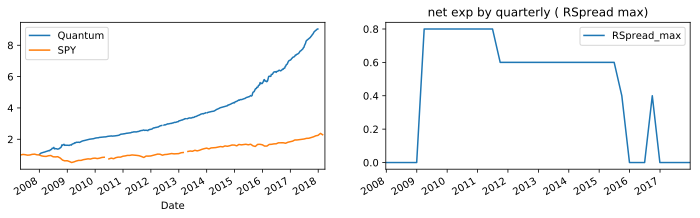

In [372]:
as_of_idx = net_exp_port.head(1).combine_first(net_exp_port.asfreq("BQ")).dropna()
q_net_exp=pd.DataFrame([],index=as_of_idx.index.tolist(),columns=["RSpread_max"])
df=pd.DataFrame([])#,index=net_exp_port.index)

last=str(as_of_idx.index.tolist()[0].date())
for i in as_of_idx.index.tolist():
    aux=net_exp_port[:i]
    if len(aux)>1:
        port_risk_matrix = lambda x: pd.Series([x for x in ts_metrics(x)], index=TS_METRICS_LEGEND)
        risk_matrix = aux.apply(port_risk_matrix)
        net_exposure = float(risk_matrix.loc['RSpread'].argmax())
        q_net_exp.loc[i]=net_exposure
        df=df.combine_first(get_return(str(net_exposure),str(i.date()),last))
        last=str(i.date())

q_net_exp
q_net_exp
df.columns=["Quantum"]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,3), dpi=300)
np.cumprod(df.drop_duplicates().asfreq("W-WED")).plot(ax=ax1, x_compat=True)
compound(px_spy.asfreq("BM")).plot(ax=ax1, x_compat=True)
q_net_exp.plot(ax=ax2)
plt.title("net exp by quarterly ( RSpread max)")
plt.show()

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel_launcher.py:112: RuntimeWarning: invalid value encountered in double_scalars


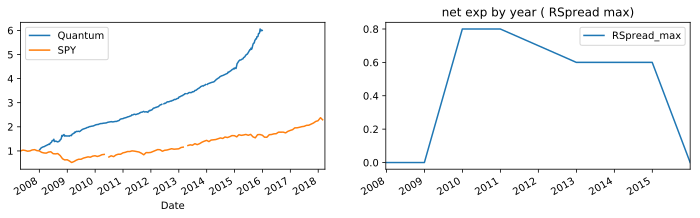

In [374]:
as_of_idx = net_exp_port.head(1).combine_first(net_exp_port.asfreq("A")).dropna()
a_net_exp=pd.DataFrame([],index=as_of_idx.index.tolist(),columns=["RSpread_max"])
df=pd.DataFrame([])#,index=net_exp_port.index)

last=str(as_of_idx.index.tolist()[0].date())
for i in as_of_idx.index.tolist():
    aux=net_exp_port[:i]
    if len(aux)>1:
        port_risk_matrix = lambda x: pd.Series([x for x in ts_metrics(x)], index=TS_METRICS_LEGEND)
        risk_matrix = aux.apply(port_risk_matrix)
        net_exposure = float(risk_matrix.loc['RSpread'].argmax())
        a_net_exp.loc[i]=net_exposure
        df=df.combine_first(get_return(str(net_exposure),str(i.date()),last))
        last=str(i.date())


a_net_exp
df.columns=["Quantum"]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,3), dpi=300)
np.cumprod(df.drop_duplicates().asfreq("W-WED")).plot(ax=ax1, x_compat=True)
compound(px_spy.asfreq("BM")).plot(ax=ax1, x_compat=True)
a_net_exp.plot(ax=ax2)
plt.title("net exp by year ( RSpread max)")
plt.show()